### 1. Import Dependencies

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2. Loading Data

In [106]:
# Load data
df = pd.read_csv('../data/processed/CountryData_Preprocessed.csv')
X = df.select_dtypes(include=[np.number]).values
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


### 3. Helper Functions

In [107]:
def pairwise_distances(X):
    """
    Compute full Euclidean distance matrix manually.
    X: (n_samples, n_features)
    """
    n = X.shape[0]
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = np.sqrt(np.sum((X[i] - X[j]) ** 2))
            dist[i, j] = d
            dist[j, i] = d
    return dist


def knn(dist_matrix, n_neighbors=10):
    """
    Find K nearest neighbors indices and distances manually.
    """
    n = dist_matrix.shape[0]
    indices = np.zeros((n, n_neighbors), dtype=int)
    distances = np.zeros((n, n_neighbors))
    for i in range(n):
        idx = np.argsort(dist_matrix[i])[1:n_neighbors + 1]
        indices[i] = idx
        distances[i] = dist_matrix[i, idx]
    return distances, indices


def fuzzy_simplicial_set(distances, n_neighbors=10):
    """
    Build fuzzy graph weights (approximation of UMAP’s fuzzy set).
    """
    n_samples = distances.shape[0]
    sigmas = np.zeros(n_samples)
    rhos = np.zeros(n_samples)
    weights = np.zeros_like(distances)

    for i in range(n_samples):
        rho = distances[i, 0]
        rhos[i] = rho
        # Binary search for sigma
        low, high = 0, np.inf
        target = np.log2(n_neighbors)
        for _ in range(30):
            sigma = (low + high) / 2 if high < np.inf else (low or 1)
            psum = np.sum(np.exp(-(np.maximum(0, distances[i] - rho)) / sigma))
            if np.abs(psum - target) < 1e-5:
                break
            if psum > target:
                high = sigma
            else:
                low = sigma
        sigmas[i] = sigma
        weights[i] = np.exp(-(np.maximum(0, distances[i] - rho)) / sigmas[i])

    return weights, sigmas, rhos


def symmetrize_graph(indices, weights, n_samples):
    """
    Build and symmetrize adjacency graph.
    """
    graph = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j, idx in enumerate(indices[i]):
            graph[i, idx] = weights[i, j]
    sym_graph = graph + graph.T - graph * graph.T
    return sym_graph

### 4. Simplified UMAP Optimization

In [108]:
def umap_manual(X, n_neighbors=10, n_components=2, n_epochs=200, lr=0.5):
    """
    Basic UMAP-like optimization loop (pure NumPy).
    """
    # Step 1: Distance matrix
    dist_matrix = pairwise_distances(X)

    # Step 2: KNN graph
    distances, indices = knn(dist_matrix, n_neighbors)

    # Step 3: Fuzzy graph
    weights, _, _ = fuzzy_simplicial_set(distances, n_neighbors)
    graph = symmetrize_graph(indices, weights, X.shape[0])

    # Step 4: Random low-dimensional initialization
    Y = np.random.normal(scale=0.01, size=(X.shape[0], n_components))

    # Step 5: Optimization
    for epoch in range(n_epochs):
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                if graph[i, j] <= 0:
                    continue
                diff = Y[i] - Y[j]
                dist_sq = np.dot(diff, diff)
                grad = -4 * graph[i, j] * diff / (1.0 + dist_sq)
                Y[i] += lr * grad
        if epoch % 50 == 0:
            print(f"Epoch {epoch}/{n_epochs}")
    return Y

### 5. Apply UMAP and Save Results

In [109]:
embedding = umap_manual(X, n_neighbors=10, n_components=2, n_epochs=200, lr=0.5)
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df.to_csv("../data/processed/custom_umap.csv", index=False)
umap_df

Epoch 0/200
Epoch 50/200
Epoch 100/200
Epoch 150/200


,UMAP1,UMAP2
0,0.764373,1.032280
1,0.383639,0.282108
2,0.792584,1.018135
3,0.785437,1.044647
4,0.263947,-0.089092
...,...,...
162,0.653762,0.839825
163,0.784402,1.017179
164,0.059122,-0.069875
165,0.784534,1.019877


### 6. Plot Results

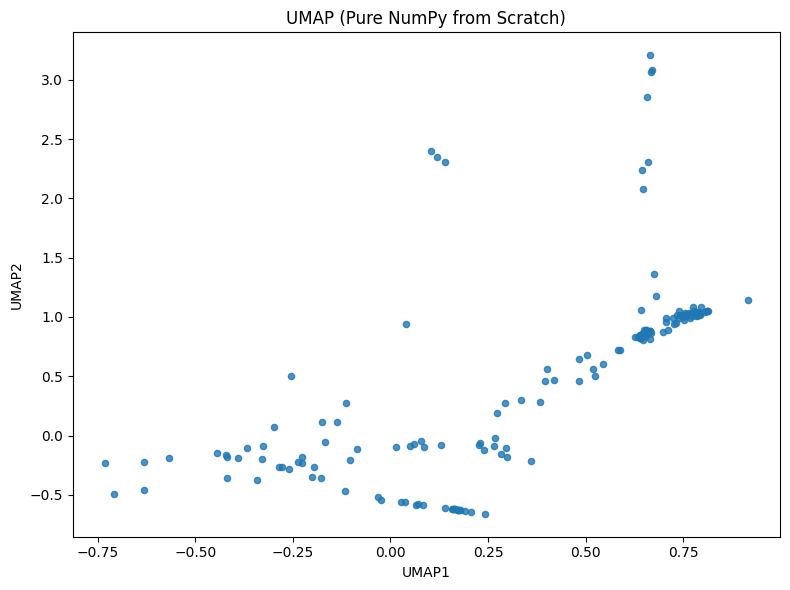

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], s=20, alpha=0.8)
plt.title("UMAP (Pure NumPy from Scratch)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.savefig("../artifacts/figures/UMAP_clusters.png", dpi=300)
plt.show()